# TP Data Science - Apprentissage Surpevisé


## Etude du jeu de données "BreastCancer"

In [3]:
# Import des librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import graphviz
plt.ion()

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score

import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
plt.style.use('dark_background')

### Données

In [4]:
# Import
df_cancer = pd.read_csv('data/df_breastCancer.csv', delimiter = ';')
df_cancer

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [7]:
# Séparation valeurs et diagnostic
X = df_cancer.drop('diagnosis', axis = 1)
y = df_cancer.diagnosis

# Filtrage de features
# regex = '_worst|_se' # On ne regarde que les moyennes
# X = X.drop(X.filter(regex=regex).columns, axis = 1)

# Codage des catégories. B = 0, M = 1
y = y.replace('B', 0)
y = y.replace('M', 1)

df_cancer.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

### Sélection des features


#### Visualisation des variables

On peut tout d'abord essayer de déterminer visuellement les features qui semblent le moins pertinentes. L'idée est de conserver les features qui fournissent une séparation nette entre les deux classes.

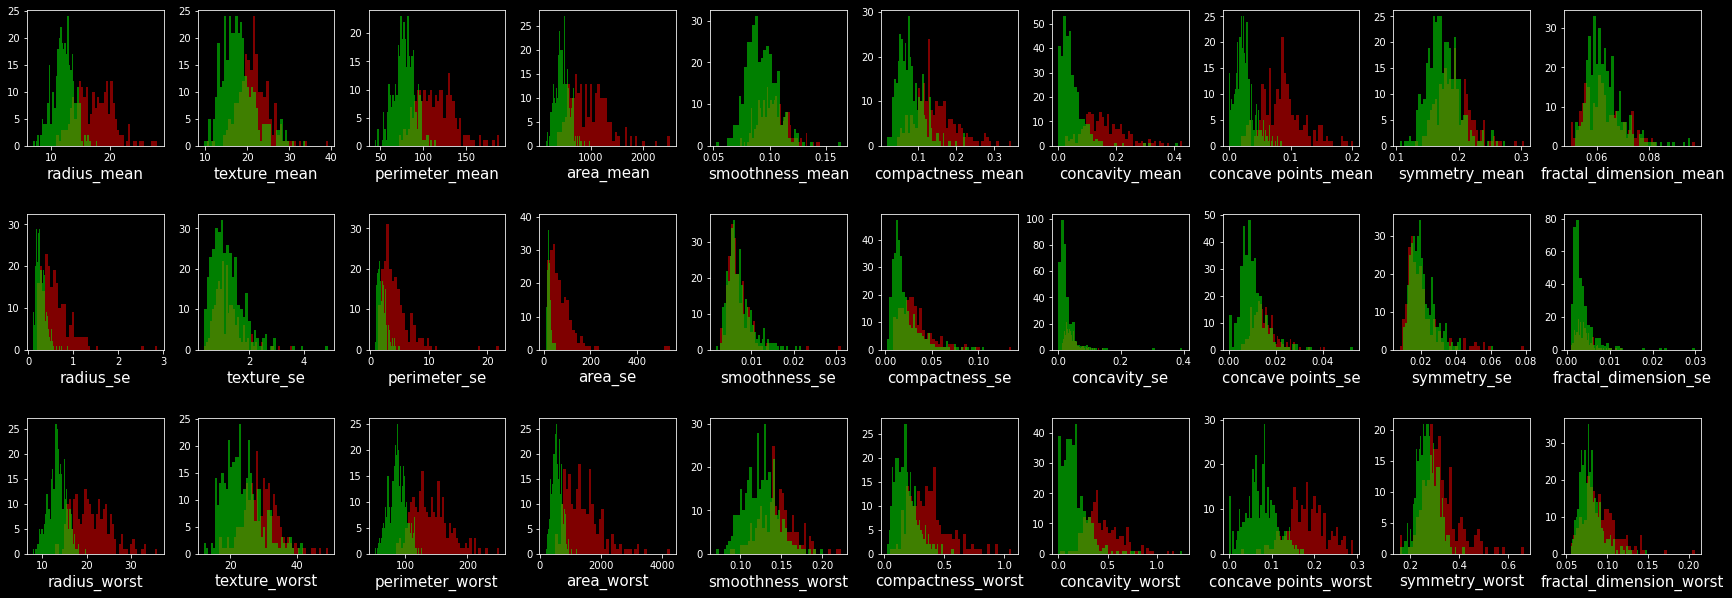

In [8]:
# Historgramme

fig, axs = plt.subplots(3, 10, figsize=(30, 10))
fig.subplots_adjust(hspace = .5, wspace=.25)
axs = axs.ravel()

for i, c in enumerate(X.columns):
    m = axs[i].hist(X[y == 1][c],bins=45,fc = (1,0,0,0.5))
    b = axs[i].hist(X[y == 0][c],bins=45,fc = (0,1,0,0.5))
    axs[i].set_xlabel(c, fontsize=15)

In [10]:
# Sélection visuelle :
drop_features_hist = []
drop_features_hist.extend(['smoothness_mean', 'symmetry_mean', 'fractal_dimension_mean'])
drop_features_hist.extend(['texture_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se']) 
drop_features_hist.extend(['smoothness_worst', 'fractal_dimension_worst']) 

X_selected_hist = X.drop(drop_features_hist, axis=1)

#### Multi-corrélations
La figure suivante montre que beaucoup de features ont des facteurs de corrélation positifs et proches de 1. Cela signifie que ces paramètres expliquent la même chose que les autres. L'idéal serait donc de s'en débarrasser pour améliorer la performance du modèle.

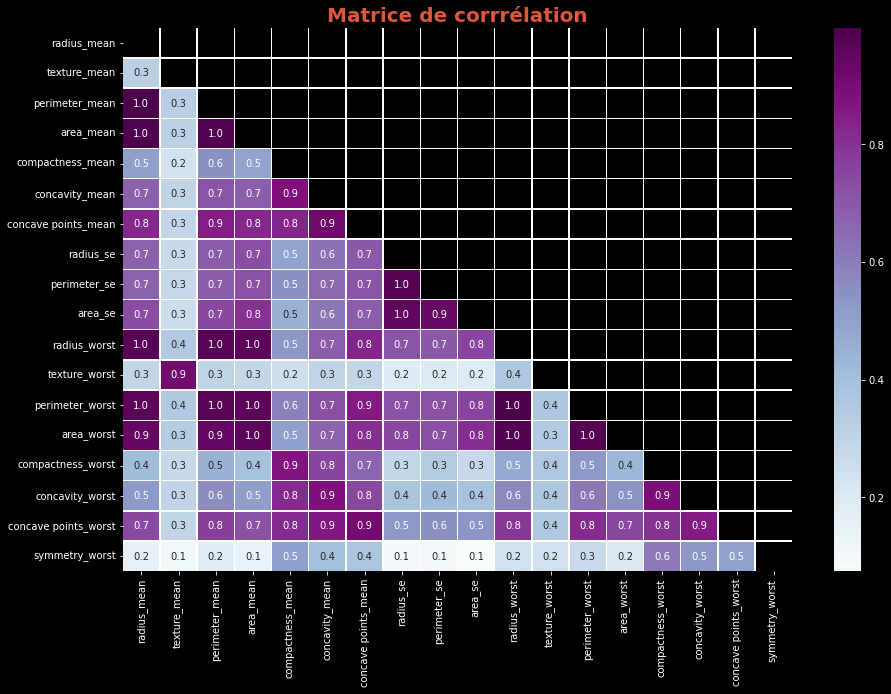

In [11]:
correlations = X_selected_hist.corr()
masque = np.triu(np.ones_like(correlations, dtype = bool))

plt.figure(figsize=(15, 10))
sns.heatmap(correlations,
            mask = masque,
            cmap = 'BuPu',
            annot = True,
            linewidths = 0.5,
            fmt = ".1f")

plt.title('Matrice de corrrélation',
          fontsize = 20,
          weight = 'semibold',
          color = '#de573c'
         )

plt.show()

#### Facteur d'Inflation de Variance (VIF)
On utilise le Facteur d'Inflation de Variance pour déterminer les features qui font l'objet d'une trop grande multi-colinéarité. Si le VIF d'un paramètre dépasse 10, alors celui-ci va réduire la fiabilité de notre modèle.

In [12]:
def VIF(df):
    vif = pd.DataFrame()
    vif['feature'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, col) for col in range(len(df.columns))]
    return vif

vif_df = VIF(X_selected_hist).sort_values('VIF', ascending = False, ignore_index = True)
print(vif_df)

                 feature           VIF
0         perimeter_mean  44683.044258
1            radius_mean  39347.549722
2           radius_worst   7397.076757
3        perimeter_worst   4117.704165
4             area_worst    788.665883
5              area_mean    763.294199
6              radius_se    197.458138
7           texture_mean    172.944958
8          texture_worst    162.562532
9           perimeter_se    159.013236
10      compactness_mean    125.307164
11   concave points_mean     95.571888
12        concavity_mean     92.243249
13  concave points_worst     73.903615
14       concavity_worst     69.956015
15     compactness_worst     58.306466
16               area_se     47.578293
17        symmetry_worst     39.091391


Les valeurs sont toutes grandement supérieures à 5 (borne acceptable). On peut choisir de conserver les features dont le VIF ne dépasse pas 10000.
On peut également choisir de retirer une feature trop corrélée avec une autre (exemple : texture_worst et texture_mean).  

In [13]:
borne = 10000
drop_features_vif = vif_df[vif_df['VIF'] > borne].feature
X_selected_vif = X_selected_hist.drop(drop_features_vif, axis=1)
X_selected_vif = X_selected_vif.drop('texture_mean', axis=1)

In [14]:
# Features conservées :
print('Features conservées :', X_selected_vif.columns.values)
print('{}/{} features ont été conservées.'.format( len(X_selected_vif.columns), len(X.columns)))

Features conservées : ['area_mean' 'compactness_mean' 'concavity_mean' 'concave points_mean'
 'radius_se' 'perimeter_se' 'area_se' 'radius_worst' 'texture_worst'
 'perimeter_worst' 'area_worst' 'compactness_worst' 'concavity_worst'
 'concave points_worst' 'symmetry_worst']
15/30 features ont été conservées.





### Découpage entre données d'apprentissage (66%) et de test (33%)

In [18]:
# Normalisation des valeurs :
X_selected_vif = StandardScaler().fit_transform(X_selected_vif)
X_train, X_test, y_train, y_test = train_test_split(X_selected_vif, y, test_size=0.33)
print(len(X_train),'données d\'apprentissage')
print(len(X_test),'données de test')

381 données d'apprentissage
188 données de test


## Modèle linéaire

### Entrainement

In [19]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

ldaScore_train = "%.3f" % lda.score(X_train, y_train)
ldaScore_test = "%.3f" % lda.score(X_test, y_test)

print("Train:",ldaScore_train)
print("Test:",ldaScore_test)

Train: 0.961
Test: 0.947


### Mesures d'évaluation

In [20]:
def printEval(predict_train, expected_train, predict_test, expected_test):
    _eval = precision_recall_fscore_support(expected_train, predict_train, average=None)
    print("Train")
    print("  - Precision 0 :", _eval[0][0].round(3))
    print("  - Precision 1 :", _eval[0][1].round(3))
    print("  - Recall 0 :", _eval[1][0].round(3))
    print("  - Recall 1 :", _eval[1][1].round(3))
    print("  - F-mesure 0 :", _eval[2][0].round(3))
    print("  - F-mesure 1 :", _eval[2][1].round(3))
    
    _eval = precision_recall_fscore_support(expected_test, predict_test, average=None)
    print("Test")
    print("  - Precision 0 :", _eval[0][0].round(3))
    print("  - Precision 1 :", _eval[0][1].round(3))
    print("  - Recall 0 :", _eval[1][0].round(3))
    print("  - Recall 1 :", _eval[1][1].round(3))
    print("  - F-mesure 0 :", _eval[2][0].round(3))
    print("  - F-mesure 1 :", _eval[2][1].round(3))

In [21]:
printEval(lda.predict(X_train), y_train, lda.predict(X_test), y_test)

Train
  - Precision 0 : 0.948
  - Precision 1 : 0.985
  - Recall 0 : 0.992
  - Recall 1 : 0.908
  - F-mesure 0 : 0.969
  - F-mesure 1 : 0.945
Test
  - Precision 0 : 0.928
  - Precision 1 : 0.984
  - Recall 0 : 0.991
  - Recall 1 : 0.873
  - F-mesure 0 : 0.959
  - F-mesure 1 : 0.925


### Courbe ROC

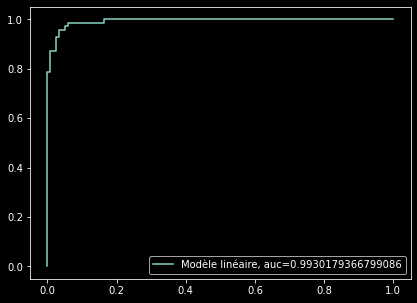

In [22]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
y_pred_proba = lda.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Modèle linéaire, auc="+str(auc))
plt.legend(loc=4)

## Modèle PMC

### Entrainement

In [24]:
alpha = 1e-03
epsilon = 1e-08

modelPMC = MLPClassifier(activation='relu', alpha= alpha, batch_size='auto', beta_1=0.9,
                          beta_2=0.999, early_stopping=False, epsilon=epsilon,
                          hidden_layer_sizes=(100,), learning_rate='constant',
                          learning_rate_init=0.001, max_iter=800, momentum=0.9,
                          n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                          random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
                          validation_fraction=0.1, verbose=False, warm_start=False)

modelPMC.fit(X_train, y_train)

modelPMC_score_train = "%.3f" % modelPMC.score(X_train, y_train)
modelPMC_score_test = "%.3f" % modelPMC.score(X_test, y_test)

print("Train:",modelPMC_score_train)
print("Test:",modelPMC_score_test)
printEval(modelPMC.predict(X_train), y_train, modelPMC.predict(X_test), y_test)

Train: 1.000
Test: 0.952
Train
  - Precision 0 : 1.0
  - Precision 1 : 1.0
  - Recall 0 : 1.0
  - Recall 1 : 1.0
  - F-mesure 0 : 1.0
  - F-mesure 1 : 1.0
Test
  - Precision 0 : 0.958
  - Precision 1 : 0.943
  - Recall 0 : 0.966
  - Recall 1 : 0.93
  - F-mesure 0 : 0.962
  - F-mesure 1 : 0.936


### Coube ROC

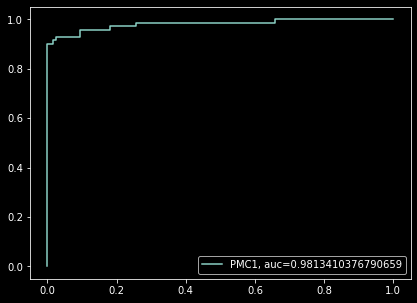

In [25]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
y_pred_proba = modelPMC.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="PMC1, auc="+str(auc))
plt.legend(loc=4)

In [26]:
alpha = 1
modelPMC2 = MLPClassifier(activation='relu', alpha= alpha, batch_size='auto', beta_1=0.9,
                          beta_2=0.999, early_stopping=False, epsilon=epsilon,
                          hidden_layer_sizes=(50,), learning_rate='constant',
                          learning_rate_init=0.001, max_iter=5000, momentum=0.9,
                          n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                          random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
                          validation_fraction=0.1, verbose=False, warm_start=False)

modelPMC2.fit(X_train, y_train)

modelPMC2_score_train = "%.3f" % modelPMC2.score(X_train, y_train)
modelPMC2_score_test = "%.3f" % modelPMC2.score(X_test, y_test)
print("Train:",modelPMC2_score_train)
print("Test:",modelPMC2_score_test)

Train: 0.987
Test: 0.957


## Arbre de décision

### Entrainement

In [27]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)

dtScore_train = "%.3f" % dt.score(X_train, y_train)
dtScore_test = "%.3f" % dt.score(X_test, y_test)

print("Train:",dtScore_train)
print("Test:",dtScore_test)
printEval(dt.predict(X_train), y_train, dt.predict(X_test), y_test)

Train: 1.000
Test: 0.926
Train
  - Precision 0 : 1.0
  - Precision 1 : 1.0
  - Recall 0 : 1.0
  - Recall 1 : 1.0
  - F-mesure 0 : 1.0
  - F-mesure 1 : 1.0
Test
  - Precision 0 : 0.956
  - Precision 1 : 0.88
  - Recall 0 : 0.923
  - Recall 1 : 0.93
  - F-mesure 0 : 0.939
  - F-mesure 1 : 0.904


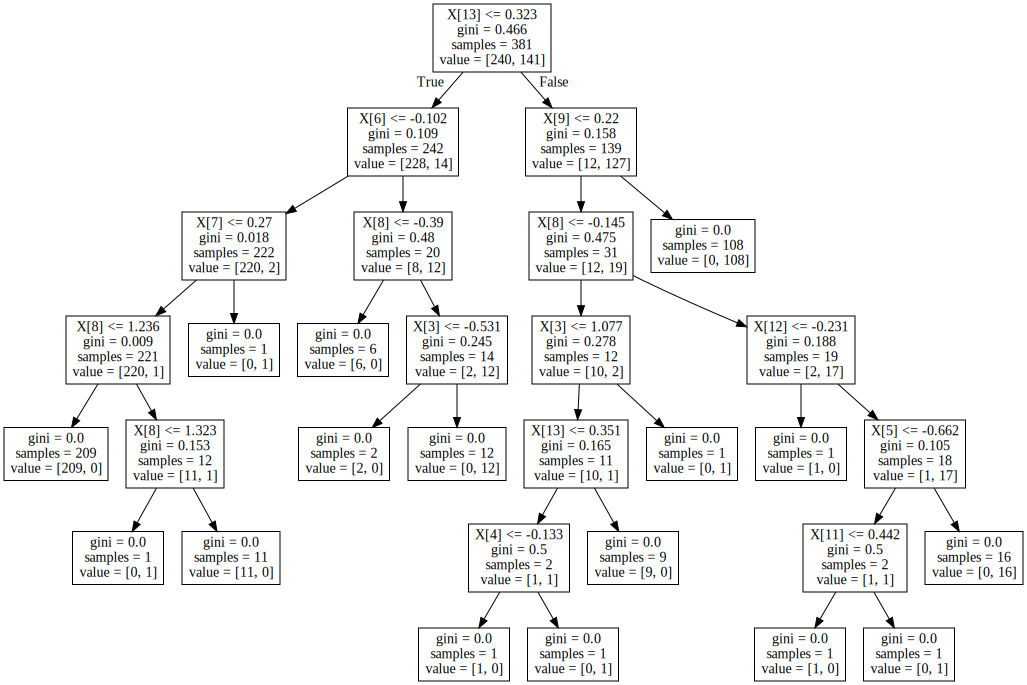

In [28]:
dot_data = tree.export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data)
graph 

### Courbe ROC

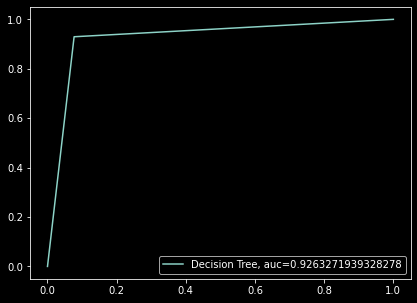

In [29]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
y_pred_proba = dt.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Decision Tree, auc="+str(auc))
plt.legend(loc=4)

## Résultats

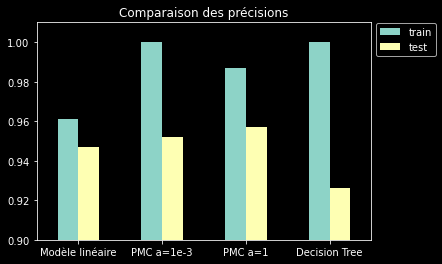

In [30]:
x = ["Modèle linéaire", "PMC a=1e-3", "PMC a=1", "Decision Tree"]
train_scores = [ldaScore_train, modelPMC_score_train, modelPMC2_score_train, dtScore_train]
test_scores = [ldaScore_test, modelPMC_score_test, modelPMC2_score_test, dtScore_test]

df = pd.DataFrame(data={'train': train_scores, 'test': test_scores}, index=x)
df=df.astype(float)
ax = df.plot(kind='bar', rot=0, title='Comparaison des précisions', figsize=(6, 4))
ax.margins(y=0.1)
ax.set_ylim(0.9, 1.01)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')